In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
from google.colab import drive
import datetime

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_zip   = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/animals-v1.zip'
dataset = '/content/animals-v1'

In [ ]:
!rm -rf {dataset}

In [ ]:
!unzip -q {dataset_zip} -d {'/content/'}

In [ ]:
# словарь с таблицами вероятностей
labels = {}
labels['pecora']       = [1,0,0]
labels['ragno']         = [0,1,0]
labels['scoiattolo']     = [0,0,1]

# список для удобного обращения к названию по индексу
labels_list = ["pecora", "ragno", "scoiattolo"]

In [ ]:
def smart_trimming(img):
  img_w, img_h = img.size   # Берём размер картинки
  target_size = [120, 120]  # Размер, который мы должны получить в результате

  # Проверка на формат
  if img_w > img_h:
    new_h = target_size[1]                # Высота - основная ось
    new_w = round(new_h / img_h * img_w)  # Вычисление ширины
  else:
    new_w = target_size[0]                # Ширина - основная ось
    new_h = round(new_w / img_w * img_h)  # Вычисление высоты

  # Изменения касательно размеров
  img = img.resize((new_w, new_h), Image.ANTIALIAS)

  # Поиск центра картинки
  center = [new_w//2, new_h//2]

  # Поиск координат для прямоугольной обрезки
  top_left = [center[0] - target_size[0]//2, center[1] - target_size[1]//2]
  bottom_right = [center[0] + target_size[0]//2, center[1] + target_size[1]//2]

  # Обрезка изображения
  img = img.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

  return img

In [ ]:
# списки с путями к картинкам
image_list = []
test_image_list = []

In [ ]:
# проход по папкам с изображениями
for label in labels.keys():
  dir = dataset +"/" + label
  flist = os.listdir(dataset + "/" + label)
  img_for_test = 0
  for f in flist:
    # Заполнение списка путей тестовой выборки
    if img_for_test < 2:
      fpath = dataset+ "/" + label + "/" + f
      test_image_list.append(fpath)
      
      img_for_test += 1
    # Заполнение списка путей обучающщей выборки
    else:
      fpath = dataset+ "/" + label + "/" + f
      image_list.append(fpath)

In [ ]:
# перемешивание списков, чтобы учить н.с. на изображениях в случайном порядке
random.shuffle(image_list)
random.shuffle(test_image_list)

# Списки для выборок
x_train = []
y_train = []

x_test = []
y_test = []

In [ ]:
# Заполнение тестовых выборок
for fpath in test_image_list:
  img = Image.open(fpath)
  img = smart_trimming(img) # Приведение к единому формату

  img = np.array(img)

  # Проверка, на случай, если функция умной обрезки несработала и не выдала ошибку
  if img.shape == (120, 120, 3):
    x_test.append(img)

    label = fpath.split('/')[3] # Получение верного ответа из пути
    y_test.append(labels[label])

In [ ]:
# Заполнение обучающей выборки
for fpath in image_list:
  img = Image.open(fpath)
  img = smart_trimming(img) # Приведение к единому формату

  img = np.array(img)

  # Проверка, на случай, если функция умной обрезки несработала и не выдала ошибку
  if img.shape == (120, 120, 3):
    x_train.append(img)

    label = fpath.split('/')[3] # Получение верного ответа из пути
    y_train.append(labels[label])

In [ ]:
# Вывод размерностей выборок для проверки и определения, сколько от них забрать для проверочной выборки
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

8496 8496
6 6


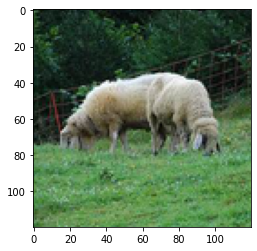

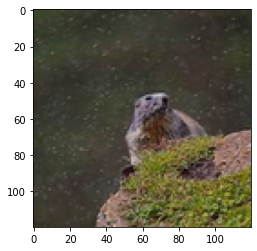

In [ ]:
# проверка картинок в списках
plt.imshow(x_train[74])
plt.show()

plt.imshow(x_test[3])
plt.show()

In [ ]:
# проверка размерностей картинок в списках
print(x_train[74].shape)
print(x_test[3].shape)

(120, 120, 3)
(120, 120, 3)


In [ ]:
# Перевод списков в np.array Этот формат массивов необх. для обучения н.с.

x_train = np.array(x_train, dtype='uint8')
y_train = np.array(y_train, dtype='uint8')

In [ ]:
# Создание валидационной выборки

x_val = x_train[8000:]
y_val = y_train[8000:]

x_train = x_train[:8000]
y_train = y_train[:8000]

x_test = np.array(x_test)
y_test = np.array(y_test)

# проверяем размер x_val
print(x_val.shape)
print(y_val.shape)

(496, 120, 120, 3)
(496, 3)


In [32]:
# Возьму функциональную н.с. за основу

batch_size = 16

img_input = Input((120, 120, 3))

# Ветка 1

x = BatchNormalization()(img_input)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

# Ветка 2

y = BatchNormalization()(img_input)
y = Conv2D(32, (2, 2), padding='same', activation='relu')(y)
y = MaxPooling2D()(y)
y = Dropout(0.3)(y)

y = BatchNormalization()(y)
y = Conv2D(64, (2, 2), padding='same', activation='relu')(y)
y = MaxPooling2D()(y)
y = Dropout(0.3)(y)

# Объединение веток
a = concatenate([x,y])

a = BatchNormalization()(a)
a = Conv2D(128, (3, 3), padding='same', activation='relu')(a)
a = MaxPooling2D()(a)
a = Dropout(0.3)(a)

a = BatchNormalization()(a)
a = Flatten()(a)
a = Dense(3, activation='softmax')(a)

model_func = Model(img_input, a)

In [33]:
# Описание модели
model_func.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 120, 120, 3)  12         ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_19 (BatchN  (None, 120, 120, 3)  12         ['input_4[0][0]']                
 ormalization)                                                                              

Epoch 1/10
500/500 [==============================] - 9s 15ms/step - loss: 5.2795 - accuracy: 0.6746 - val_loss: 0.6037 - val_accuracy: 0.7399
Epoch 2/10
500/500 [==============================] - 7s 14ms/step - loss: 0.6062 - accuracy: 0.7707 - val_loss: 0.6241 - val_accuracy: 0.7540
Epoch 3/10
500/500 [==============================] - 7s 14ms/step - loss: 0.5792 - accuracy: 0.7795 - val_loss: 0.6104 - val_accuracy: 0.7883
Epoch 4/10
500/500 [==============================] - 7s 14ms/step - loss: 0.5655 - accuracy: 0.7926 - val_loss: 0.6744 - val_accuracy: 0.7460
Epoch 5/10
500/500 [==============================] - 7s 14ms/step - loss: 0.6045 - accuracy: 0.7864 - val_loss: 0.6408 - val_accuracy: 0.7581
Epoch 6/10
500/500 [==============================] - 7s 15ms/step - loss: 0.6464 - accuracy: 0.7855 - val_loss: 0.7578 - val_accuracy: 0.7419
Epoch 7/10
500/500 [==============================] - 7s 14ms/step - loss: 0.7155 - accuracy: 0.7811 - val_loss: 0.5920 - val_accuracy: 0.8246

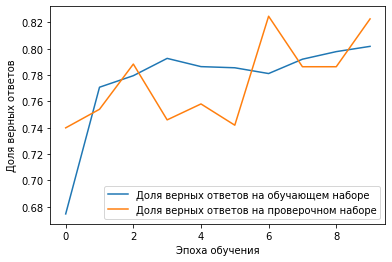

In [34]:
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=10,
                        validation_data=(x_val, y_val),
                        verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/10
500/500 [==============================] - 9s 15ms/step - loss: 0.3981 - accuracy: 0.8729 - val_loss: 0.3570 - val_accuracy: 0.8750
Epoch 2/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2730 - accuracy: 0.8972 - val_loss: 0.3307 - val_accuracy: 0.8750
Epoch 3/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2540 - accuracy: 0.9081 - val_loss: 0.3535 - val_accuracy: 0.8730
Epoch 4/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2272 - accuracy: 0.9136 - val_loss: 0.3443 - val_accuracy: 0.8730
Epoch 5/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2178 - accuracy: 0.9205 - val_loss: 0.3326 - val_accuracy: 0.8710
Epoch 6/10
500/500 [==============================] - 7s 14ms/step - loss: 0.2049 - accuracy: 0.9239 - val_loss: 0.3333 - val_accuracy: 0.8810
Epoch 7/10
500/500 [==============================] - 7s 14ms/step - loss: 0.1862 - accuracy: 0.9308 - val_loss: 0.3617 - val_accuracy: 0.8750

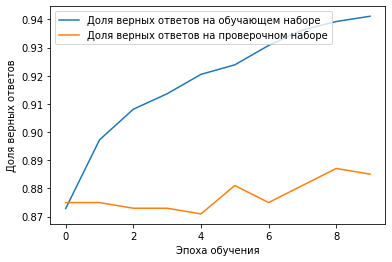

In [35]:
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

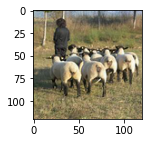

Выход сети:
[9.9570566e-01 3.6264164e-03 6.6793797e-04]

0 -> 0.9957056641578674316406250000000000000000
1 -> 0.0036264164373278617858886718750000000000
2 -> 0.0006679379730485379695892333984375000000

Распознан объект:  0 - pecora
Верный ответ:  0 - pecora


In [36]:
prediction = model_func.predict(x_test)

n = 2

img = x_test[n]
img = img.reshape(120, 120, 3)
img = img.astype('uint8')
plt.figure(figsize=(2, 2))
plt.imshow(Image.fromarray(img)) #Отображаем изображение i-ым графиков
plt.show()

print("Выход сети:")
print(prediction[n])
print()
for i in range(3):
  print(i,"->","{:.40f}".format(prediction[n][i]))
print()
# print(labels[np.argmax(prediction[n])])
print("Распознан объект: ", np.argmax(prediction[n]), "-", labels_list[np.argmax(prediction[n])])
print("Верный ответ: ", np.argmax(y_test[n]), "-", labels_list[np.argmax(y_test[n])])